In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, Image

In [2]:
data = pd.read_csv('Titanic.csv')
display(data.head())
print(data.shape)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)


In [3]:
def find_missing_percent(data , showresult = True):
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        missinginfo = {"ColumnName" : col, "TotalMissingVals" : sum_miss_val, "PercentMissing" : percent_miss_val}
        miss_df = miss_df.append(missinginfo, ignore_index = True)
    
    miss_df = miss_df[miss_df["PercentMissing"] > 0.0]
    miss_df = miss_df.reset_index(drop = True)
    miss_features = miss_df["ColumnName"].values
    if(showresult):
        print(data.shape)
        display(miss_df)
    return miss_df

In [4]:
miss_df = find_missing_percent(data)

(891, 12)


,ColumnName,TotalMissingVals,PercentMissing
0,Age,177.0,19.87
1,Cabin,687.0,77.10
2,Embarked,2.0,0.22


In [5]:
drop_cols = list(miss_df[miss_df['PercentMissing'] > 60.0].ColumnName)
print(drop_cols)
data = data.drop(drop_cols,axis=1)
miss_df = find_missing_percent(data)
display(data.head())

['Cabin']
(891, 11)


,ColumnName,TotalMissingVals,PercentMissing
0,Age,177.0,19.87
1,Embarked,2.0,0.22


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Missing Handling

In [6]:
def listwise_deletion(data):
    for col in data.columns:
        miss_ind = data[col][data[col].isnull()].index
        data = data.drop(miss_ind, axis = 0)
    return data

In [7]:
data_lwd = listwise_deletion(data)
miss_df = find_missing_percent(data_lwd)

(712, 11)


,ColumnName,TotalMissingVals,PercentMissing


In [8]:
numeric_cols = data.select_dtypes(['float','int']).columns
categoric_cols = data.select_dtypes('object').columns
print(f"Numeric Columns : {numeric_cols}")
print(f"Categoric Columns : {categoric_cols}")

Numeric Columns : Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Categoric Columns : Index(['Name', 'Sex', 'Ticket', 'Embarked'], dtype='object')


In [9]:
def mean_imputation(data_numeric):
    for col in data_numeric.columns:
        mean = data_numeric[col].mean()
        data_numeric[col] = data_numeric[col].fillna(mean)
    return data_numeric
def mode_imputation(data_categoric):
    for col in data_categoric.columns:
        mode = data_categoric[col].mode().iloc[0]
        data_categoric[col] = data_categoric[col].fillna(mode)
    return data_categoric

In [10]:
data_numeric = data[numeric_cols]
data_numeric_mean_imp = mean_imputation(data_numeric)
data_categoric = data[categoric_cols]
data_categoric_mode_imp = mode_imputation(data_categoric)

data_imputed_value = pd.concat([data_numeric_mean_imp, data_categoric_mode_imp], axis = 1)
miss_df = find_missing_percent(data_imputed_value)

(891, 11)


,ColumnName,TotalMissingVals,PercentMissing


In [11]:
import xgboost
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import (GradientBoostingRegressor, GradientBoostingClassifier)

In [12]:
def find_missing_index(data_numeric_xgboost, target_cols):
    miss_index_dict = {}
    for tcol in target_cols:
        index = data_numeric_xgboost[tcol][data_numeric_xgboost[tcol].isnull()].index
        miss_index_dict[tcol] = index
    return miss_index_dict

def xgboost_imputation(data_numeric_xgboost, target_cols, miss_index_dict):
    predictors = data_numeric_xgboost.drop(target_cols, axis =1)
    for tcol in target_cols:
        y = data_numeric_xgboost[tcol]
        y = y.fillna(y.mean())
        xgb = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
        xgb.fit(predictors, y)
        predictions = pd.Series(xgb.predict(predictors),index= y.index)    
        index = miss_index_dict[tcol]
        data_numeric_xgboost[tcol].loc[index] = predictions.loc[index]
    return data_numeric_xgboost

In [13]:
miss_df = find_missing_percent(data, showresult = False)
miss_features = miss_df["ColumnName"].values
target_cols = [feature for feature in miss_features if feature in numeric_cols]  
print(target_cols)

['Age']


In [14]:
data_numeric_xgboost = data[numeric_cols]
miss_index_dict = find_missing_index(data_numeric_xgboost, target_cols)
data_numeric_xgboost = xgboost_imputation(data_numeric_xgboost, target_cols, miss_index_dict)
data_imputed_xgboost = pd.concat([data_numeric_xgboost, data_categoric_mode_imp], axis = 1)

miss_df = find_missing_percent(data_imputed_xgboost)

(891, 11)


,ColumnName,TotalMissingVals,PercentMissing


In [15]:
def mice_imputation_numeric(train_numeric):
    iter_imp_numeric = IterativeImputer(GradientBoostingRegressor())
    imputed_train = iter_imp_numeric.fit_transform(train_numeric)
    train_numeric_imp = pd.DataFrame(imputed_train, columns = train_numeric.columns, index= train_numeric.index)
    return train_numeric_imp

def mice_imputation_categoric(train_categoric):
    ordinal_dict={}
    for col in train_categoric:
        ordinal_dict[col] = OrdinalEncoder()
        nn_vals = np.array(train_categoric[col][train_categoric[col].notnull()]).reshape(-1,1)
        nn_vals_arr = np.array(ordinal_dict[col].fit_transform(nn_vals)).reshape(-1,)
        train_categoric[col].loc[train_categoric[col].notnull()] = nn_vals_arr

    iter_imp_categoric = IterativeImputer(GradientBoostingClassifier(), max_iter =5, initial_strategy='most_frequent')
    imputed_train = iter_imp_categoric.fit_transform(train_categoric)
    train_categoric_imp = pd.DataFrame(imputed_train, columns =train_categoric.columns,index = train_categoric.index).astype(int)
    
    for col in train_categoric_imp.columns:
        oe = ordinal_dict[col]
        train_arr= np.array(train_categoric_imp[col]).reshape(-1,1)
        train_categoric_imp[col] = oe.inverse_transform(train_arr)
        
    return train_categoric_imp

In [16]:
data_numeric_imp  = mice_imputation_numeric(data_numeric)
data_categoric_imp = mice_imputation_categoric(data_categoric)

data_imputed_mice = pd.concat([data_numeric_imp, data_categoric_imp], axis = 1)
miss_df = find_missing_percent(data_imputed_mice)

(891, 11)


,ColumnName,TotalMissingVals,PercentMissing


In [17]:
def mice_imputation_numeric(train_numeric):
    iter_imp_numeric = IterativeImputer(GradientBoostingRegressor())
    imputed_train = iter_imp_numeric.fit_transform(train_numeric)
    train_numeric_imp = pd.DataFrame(imputed_train, columns = train_numeric.columns, index= train_numeric.index)
    return train_numeric_imp

def mice_imputation_categoric(train_categoric):
    ordinal_dict={}
    for col in train_categoric:
        ordinal_dict[col] = OrdinalEncoder()
        nn_vals = np.array(train_categoric[col][train_categoric[col].notnull()]).reshape(-1,1)
        nn_vals_arr = np.array(ordinal_dict[col].fit_transform(nn_vals)).reshape(-1,)
        train_categoric[col].loc[train_categoric[col].notnull()] = nn_vals_arr

    iter_imp_categoric = IterativeImputer(GradientBoostingClassifier(), max_iter =5, initial_strategy='most_frequent')
    imputed_train = iter_imp_categoric.fit_transform(train_categoric)
    train_categoric_imp = pd.DataFrame(imputed_train, columns =train_categoric.columns,index = train_categoric.index).astype(int)
    
    for col in train_categoric_imp.columns:
        oe = ordinal_dict[col]
        train_arr= np.array(train_categoric_imp[col]).reshape(-1,1)
        train_categoric_imp[col] = oe.inverse_transform(train_arr)
        
    return train_categoric_imp

In [18]:
data_numeric_imp  = mice_imputation_numeric(data_numeric)
data_categoric_imp = mice_imputation_categoric(data_categoric)

data_imputed_mice = pd.concat([data_numeric_imp, data_categoric_imp], axis = 1)
miss_df = find_missing_percent(data_imputed_mice)

(891, 11)


,ColumnName,TotalMissingVals,PercentMissing


In [19]:
data_imputed_mice.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Embarked
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,108.0,1.0,523.0,2.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,190.0,0.0,596.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,353.0,0.0,669.0,2.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,272.0,0.0,49.0,2.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,15.0,1.0,472.0,2.0


In [22]:
data_modelling = data_lwd.copy()

In [23]:
data_modelling.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [25]:
def FeatureEngineering(data_modelling):
    data_modelling['TotalPCLASS'] = data_modelling['Fare'] / data_modelling['Pclass']
    return data_modelling    

data_modelling = FeatureEngineering(data_modelling)
display(data_modelling.head())
print(data_modelling.shape)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,TotalPCLASS
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2.416667
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,71.283300
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,2.641667
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,53.100000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,2.683333


(712, 12)


In [26]:
skew_limit = 0.5
skew_vals = data_modelling[numeric_cols].skew()
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))
display(skew_cols.T)

,Fare,Parch,SibSp
Skew,4.667009,2.614177,2.515107


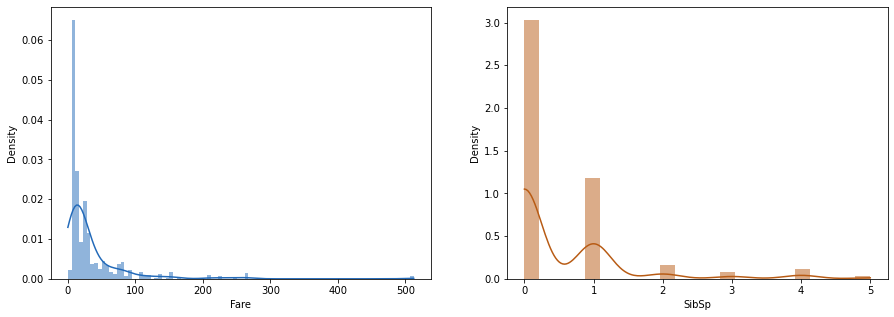

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_modelling['Fare'],kde=True, stat='density', linewidth=0, color = '#236AB9', ax=ax1)
sns.histplot(data_modelling['SibSp'], kde=True, stat='density', linewidth=0,color='#B85B14', ax=ax2)
plt.show()

In [32]:
def NormalizeSkewedFeatures(data_modelling):
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    for col in skew_cols.index:
        if(col != 'Survived'):
            try:
                data_modelling[col] = boxcox1p(data_modelling[col], boxcox_normmax(data_modelling[col] + 1))
            except:
                print(f"column {col} can not apply BoxCox")
                continue
    return data_modelling

data_modelling = NormalizeSkewedFeatures(data_modelling)
data_modelling["Survived"] = np.log1p(data_modelling["Survived"])

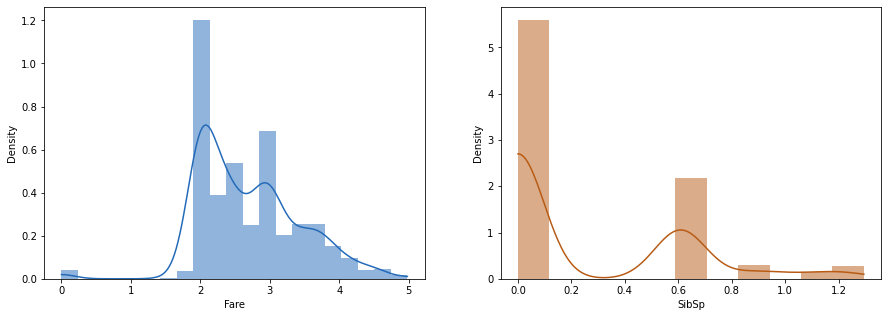

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_modelling['Fare'],kde=True, stat='density', linewidth=0, color = '#236AB9', ax=ax1)
sns.histplot(data_modelling['SibSp'], kde=True, stat='density', linewidth=0,color='#B85B14', ax=ax2)
plt.show()

In [34]:
def FeatureEncoding(data_modelling):
    data_modelling = pd.get_dummies(data_modelling, columns=categoric_cols, drop_first=True)   
    return data_modelling

data_modelling = FeatureEncoding(data_modelling)
display(data_modelling.head())
print(data_modelling.shape)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,TotalPCLASS,"Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)",...,Ticket_STON/O2. 3101290,Ticket_SW/PP 751,Ticket_W./C. 14258,Ticket_W./C. 14263,Ticket_W./C. 6608,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_Q,Embarked_S
0,1,0.000000,3,22.0,0.608512,0.0,1.951200,2.416667,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0.693147,1,38.0,0.608512,0.0,3.659614,71.283300,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0.693147,3,26.0,0.000000,0.0,2.018098,2.641667,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,0.693147,1,35.0,0.608512,0.0,3.447343,53.100000,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0.000000,3,35.0,0.000000,0.0,2.029888,2.683333,0,0,...,0,0,0,0,0,0,0,0,0,1


(712, 1262)


In [36]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def DataSplitTrainTest(data_modelling):
    train = data_modelling.copy()
    X = train.drop('Survived', axis=1)
    y = train['Survived']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)
    print("Train Data", X_train.shape)
    print("Test Data", X_test.shape)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = DataSplitTrainTest(data_modelling)

Train Data (498, 1261)
Test Data (214, 1261)


In [37]:
def BuildLassoModel(X_train, X_test, y_train, y_test):
    lasso = Lasso(max_iter = 100000, normalize = True)
    lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
    lassocv.fit(X_train, y_train)

    lasso.set_params(alpha=lassocv.alpha_)
    lasso.fit(X_train, y_train)

    print('The Lasso:')
    print("Alpha =", lassocv.alpha_)
    print("RMSE =", mean_squared_error(y_test, lasso.predict(X_test), squared=False))
    print("R2 Score = ", r2_score(y_test, lasso.predict(X_test)))
    return lasso

lasso = BuildLassoModel(X_train, X_test, y_train, y_test)

The Lasso:
Alpha = 0.0008706366476351458
RMSE = 0.25507452174963907
R2 Score =  0.4270417158046158


In [38]:
def BuildRidgeModel(X_train, X_test, y_train, y_test):
    alphas = np.geomspace(1e-9, 5, num=100)
    ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
    ridgecv.fit(X_train, y_train)

    ridge = Ridge(alpha = ridgecv.alpha_, normalize = True)
    ridge.fit(X_train, y_train)

    print('Ridge Regression:')
    print("Alpha =", ridgecv.alpha_)
    print("RMSE =", mean_squared_error(y_test, ridge.predict(X_test), squared=False))
    print("R2 Score = ", r2_score(y_test, lasso.predict(X_test)))
    return ridge

ridge = BuildRidgeModel(X_train, X_test, y_train, y_test)

Ridge Regression:
Alpha = 1e-09
RMSE = 0.28281595122510556
R2 Score =  0.4270417158046158
